# Title
A Deep Q-Learnig implementation to solve Breakout. Using ConvNets, double DQN, replay memory and image transformations.

## Links
1. https://github.com/lazyprogrammer/machine_learning_examples/blob/master/rl2/atari/dqn_tf.py
1. https://medium.com/@shivamrawat_756/how-to-prevent-google-colab-from-disconnecting-717b88a128c0
1. https://arxiv.org/abs/1312.5602
1. https://arxiv.org/abs/1509.06461
1. https://major.io/2009/06/15/two-great-signals-sigstop-and-sigcont/

## Prevent disconnect on Colab
`function ClickConnect(){console.log("Working");document.querySelector("colab-connect-button").shadowRoot.getElementById("connect").click()}setInterval(ClickConnect,60000)`

## Init (libs, video render etc)

In [1]:
# !pip install tensorflow==2.1

# render video
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1
# !pip install atari_py > /dev/null 2>&1
# !apt install -y ffmpeg > /dev/null 2>&1

### Libs

In [2]:
%reset -f
import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from IPython import display
# import datetime
from datetime import datetime
# import PIL
# from scipy.misc import imresize

%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

# Eager by default!
print("Eager Execution:", tf.executing_eagerly())
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

np.random.seed(42)
tf.random.set_seed(42)
tf.config.list_physical_devices('GPU')

TensorFlow Ver:  2.1.0
Eager Execution: True
1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Video

In [3]:
# from gym import logger as gymlogger
# from gym.wrappers import Monitor
# import math
# import glob
# import io
# import base64
# from IPython.display import HTML

# from IPython import display as ipythondisplay

# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()


# """
# Utility functions to enable video recording of gym environment and displaying it
# To enable video, just do "env = wrap_env(env)""
# """

# def show_video():
#   mp4list = glob.glob('video/*.mp4')
#   if len(mp4list) > 0:
#     mp4 = mp4list[0]
#     video = io.open(mp4, 'r+b').read()
#     encoded = base64.b64encode(video)
#     ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
#                 loop controls style="height: 400px;">
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii'))))
#   else: 
#     print("Could not find video")
    

# def wrap_env(env):
#     env = Monitor(env, './video', force=True)
#     return env

# DQN

## Constants

In [4]:
MAX_EXPERIENCES = 50000#@param {type:"integer"}
MIN_EXPERIENCES =  5000#@param {type:"integer"}
TARGET_UPDATE_PERIOD = 10000 #@param {type:"integer"}
IM_SIZE = 84 #@param {type:"integer"}
K = 4
OPTIMIZER_LR = 1e-5#@param {type:"number"}

## Image Transformer

In [5]:
class ImageTransformer:
    def __init__(self):
        self.output = None

    def transform(self, img):
        self.output = img
        # grayscale
        self.output = tf.image.rgb_to_grayscale(self.output)
        # crop
        self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
        # resize
        self.output = tf.image.resize(self.output, [IM_SIZE, IM_SIZE], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # make 2d
        self.output = tf.squeeze(self.output)
        # print(np.shape(self.output))
        return self.output

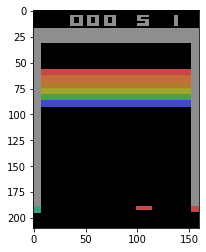

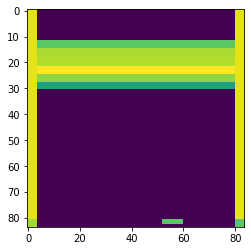

In [6]:
# test Image transformer
# get frame
env = gym.envs.make("Breakout-v0")
im = env.reset()

# collect images
im_arr = []
im_arr.append(im)

# transform
image_transformer = ImageTransformer()
im = image_transformer.transform(im)

im_arr.append(im)

# display
for im in im_arr:
    plt.figure()
    plt.imshow(im)

## Update State

In [7]:
def update_state(state, obs_small):
    return np.append(state[:,:,1:], np.expand_dims(obs_small, 2), axis = 2)

## Replay Memory

In [8]:
class ReplayMemory:
    def __init__(self, size = MAX_EXPERIENCES, frame_height = IM_SIZE, frame_width = IM_SIZE, agent_history_len = 4, batch_size = 32):
        """
        Args:
        size: Integer, Number of stored transitions
        frame_height: Integer, Height of a frame of an Atari game
        frame_width: Integer, Width of a frame of an Atari game
        agent_history_len: Integer, Number of frames stacked together to create a state
        batch_size: Integer, Number of transitions returned in a minibatch
        """

        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_len = agent_history_len
        self.batch_size = batch_size
        self.count = 0
        self.current = 0

        # Pre allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        self.terminal_flags = np.empty(self.size, dtype=np.bool)

        # Pre allocate memory for the states and new_states in a minibatch
        self.states = np.empty((self.batch_size, self.agent_history_len, self.frame_width, self.frame_width), dtype=np.float32)
        self.new_states = np.empty((self.batch_size, self.agent_history_len, self.frame_width, self.frame_width), dtype=np.float32)
        self.indices = np.empty(self.batch_size, dtype=np.int32)

    def add_experience(self, action, frame, reward, terminal):
        """
        Args:
        action: An integer-encoded action
        frame: One grayscale frame of the game
        reward: reward the agend received for performing an action
        terminal: A bool stating whether the episode terminated
        """
        if frame.shape != (self.frame_height, self.frame_width):
            raise ValueError('Wrong frame dims.')

        self.actions[self.current] = action
        self.frames[self.current, ...] = frame
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal

        self.count = max(self.count, self.current + 1)
        # go in circle
        self.current = (self.current + 1) % self.size

    def _get_state(self, index):
        if self.count is 0:
            raise ValueError("The replay memory is empty")
        if index < self.agent_history_len - 1:
            raise ValueError("Index must be min 3")

        return self.frames[index - self.agent_history_len + 1 : index + 1, ...]

    def _get_valid_indices(self):
        for i in range(self.batch_size):
            while True:
                index = np.random.randint(self.agent_history_len, self.count - 1)
                if index < self.agent_history_len:
                    continue
                if index >= self.current and index - self.agent_history_len <= self.current:
                    continue
                if self.terminal_flags[index - self.agent_history_len:index].any():
                    continue
                break
            self.indices[i] = index

    def get_minibatch(self):
        if self.count < self.agent_history_len:
            raise ValueError("Not enough memories to make a minibatch")

        self._get_valid_indices()

        for i, idx in enumerate(self.indices):
            self.states[i] = self._get_state(idx - 1)
            self.new_states[i] = self._get_state(idx)
        
        return np.transpose(self.states, axes = (0, 2, 3, 1)), self.actions[self.indices], self.rewards[self.indices], np.transpose(self.new_states, axes = (0, 2, 3, 1)), self.terminal_flags[self.indices]

## DQN Class

In [9]:
class DQN:
    def __init__(self, K, conv_layer_sizes = (0, 0, 0), hidden_layer_sizes = 0, scope = ""):
        self.K = K
        self.optimizer = tf.keras.optimizers.Adam(lr = OPTIMIZER_LR)
        self.loss = tf.keras.losses.Huber()

        # build model
        self.model = tf.keras.models.Sequential(name = scope)
        self.model.add(tf.keras.layers.Conv2D(32, (4), activation='relu', input_shape=(IM_SIZE, IM_SIZE, 4)))
        # self.model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        self.model.add(tf.keras.layers.Conv2D(64, (2), activation='relu'))
        # self.model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        self.model.add(tf.keras.layers.Conv2D(64, (1), activation='relu'))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(200, activation='relu'))
        self.model.add(tf.keras.layers.Dense(K, activation = "softmax"))

        self.model.summary()
        # self.model.compile(optimizer = self.optimizer,
        #                    loss = self.loss
        # )
        self.do_minimize = tf.function(self.minimize, input_signature=[
            tf.TensorSpec(shape = (None, IM_SIZE, IM_SIZE, 4), dtype = tf.float32),
            tf.TensorSpec(shape = None, dtype = tf.int32),
            tf.TensorSpec(shape = None, dtype = tf.float32)                                                  
        ])

    def minimize(self, states, actions, targets):
        def loss():
            selected_action_values = tf.reduce_sum(self.model(states) * tf.one_hot(actions, K), keepdims=True)
            cost = tf.reduce_mean(self.loss(targets, selected_action_values))
            return cost
        self.optimizer.minimize(loss, self.model.trainable_variables)

    def copy_from(self, other):
        self.model = tf.keras.models.clone_model(other.model)

    def save_model(self):
        tf.keras.models.save_model(self.model, "./model.h5")
        # self.model.save_model("./model")
    
    def load_model(self):
        self.model = tf.keras.models.load_model("./model.h5", compile=False)

    def predict(self, states):
        # preds = []
        # for state in states:
        #     preds.append(self.model.predict(states)[0])
        # # print(preds)
        # print(np.shape(preds))
        preds = self.model.predict(states)
        return preds
    
    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            x = x.reshape((1, IM_SIZE, IM_SIZE, 4))
            return np.argmax(self.predict((x)))
        

In [10]:
# test DQN class
TestModel = DQN(K)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 81, 32)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        4160      
_________________________________________________________________
flatten (Flatten)            (None, 409600)            0         
_________________________________________________________________
dense (Dense)                (None, 200)               81920200  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
Total params: 81,935,500
Trainable params: 81,935,500
Non-trainable params: 0
____________________________________________

## Learn and Play

In [11]:
def learn(model, target_model, experience_replay_buffer, gamma, batch_size):
    states, actions, rewards, next_states, dones = experience_replay_buffer.get_minibatch()
    # print("Next states")
    # print(np.shape(next_states))
    
    next_Qs = target_model.predict((next_states))
    next_Q = np.amax(next_Qs, axis = 1)
    # print(next_Q)
    targets = rewards + np.invert(dones).astype(np.float32) * gamma * next_Q

    model.do_minimize(states, actions, targets)

In [12]:
def play_one(
    env,
    total_t,
    exp_replay_buffer,
    model,
    target_model,
    image_transformer,
    gamma,
    batch_size,
    epsilon,
    epsilon_change,
    epsilon_min,
    best_reward):

    t0 = datetime.now()

    # reset env
    obs = env.reset()
    obs_small = image_transformer.transform(obs)
    state = np.stack([obs_small] * 4, axis = 2)
    
    total_time_training = 0
    num_steps_in_episode = 0
    episode_reward = 0

    done = False
    
    while not done:
        # take action
        action = model.sample_action(state, epsilon)
        obs, reward, done, _ = env.step(action)
        obs_small = image_transformer.transform(obs)
        next_state = update_state(state, obs_small)

        # copute total reward
        episode_reward += reward

        # save latest exp
        experience_replay_buffer.add_experience(action, obs_small, reward, done)

        # train model
        t_02 = datetime.now()
        learn(model, target_model, exp_replay_buffer, gamma, batch_size)
        dt = datetime.now() - t_02

        # debug
        total_time_training += dt.total_seconds()
        num_steps_in_episode += 1

        state = next_state
        total_t += 1
        
        # not used any more
        # epsilon = max(epsilon - epsilon_change, epsilon_min)

    # update target net
    if episode_reward >= best_reward:
        target_model.copy_from(model)
        print(f"Copied model parameters to target network. Current reward was >= than the best reward. Old best: {best_reward}, New best: {episode_reward}.")
        best_reward = episode_reward
#         make_video(env, model)

    return total_t, episode_reward, (datetime.now() - t0), num_steps_in_episode, total_time_training/num_steps_in_episode, epsilon, best_reward

In [13]:
def smooth(x):
    # last 100
    n = len(x)
    y = np.zeros(n)

    for i in range(n):
        start = max(0, i - 99)
        y[i] = float(x[start:(i+1)].sum()) / (i - start + 1)
    return y

# Make video

In [14]:
def make_video(env, model):
    env = wrappers.Monitor(env, os.path.join(os.getcwd(), "videos"), force=True)

    # reset env
    obs = env.reset()
    obs_small = image_transformer.transform(obs)
    state = np.stack([obs_small] * 4, axis = 2)

    total_time_training = 0
    total_steps_in_episode = 0
    episode_reward = 0

    done = False

    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    
    while not done:
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
#         env.render()
        # take action
        action = model.sample_action(state, epsilon)
        obs, reward, done, _ = env.step(action)
        obs_small = image_transformer.transform(obs)
        next_state = update_state(state, obs_small)
        # print("Action: ", action)

        # copute total reward
        episode_reward += reward
        total_steps_in_episode += 1
    print("Testing steps: {} rewards {}: ".format(total_steps_in_episode, episode_reward))
    env.close()
    # show_video()

# Main

In [15]:
def plot_prog(episode_rewards, curr_n):
    episode_rewards = episode_rewards[0 : curr_n]
    y = smooth(episode_rewards)
    plt.plot(episode_rewards, label='orig')
    plt.plot(y, label='smoothed')
    plt.xlabel("n")
    plt.ylabel("reward")
    plt.legend()
    plt.show()

In [16]:
def get_eps(e_start, e_end, N, n):
    a = (e_end - e_start)/(1/3 * N)
    # print(a)
    return max(a*n + e_start, 0.1)

In [17]:
def plot_epsilon(e_start, e_end, N):
    eps = []
    for n in range(N):
        eps.append(get_eps(e_start, e_end, N, n))

    plt.plot(eps)
    plt.xlabel("n")
    plt.ylabel('eps')
    plt.title("Epsilon change over time")
    plt.show()

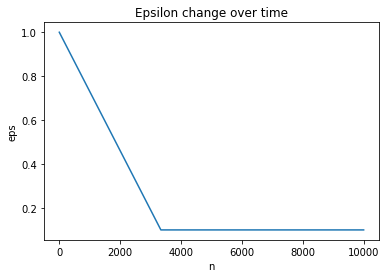

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 81, 81, 32)        2080      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 80, 64)        8256      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 80, 64)        4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 409600)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               81920200  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 804       
Total params: 81,935,500
Trainable params: 81,935,500
Non-trainable params: 0
_________________________________________________

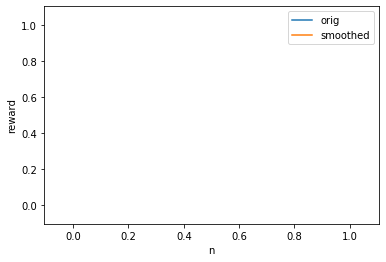

Episode: 0 	Duration: 0:01:15.719176 	Num steps: 337 	Reward: 3.0 	Training time per step: 0.128 	Avg Reward (Last 100): 3.000 	Epsilon: 1.000
Total duration: 0:01:15.856980
Copied model parameters to target network. Current reward was >= than the best reward. Old best: 3.0, New best: 5.0.


ResourceExhaustedError: OOM when allocating tensor with shape[409600,200] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_2_3/kernel/Initializer/random_uniform/

In [18]:
if __name__ == "__main__":
    conv_layer_sizes = [(32, 8, 4), (64, 4, 2), (64, 3, 1)]
    hidden_layer_sizes = [512]
    gamma = 0.99#@param {type:"number"}
    batch_sz = 32#@param {type:"integer"}
    num_episodes = 10000#@param {type:"integer"}
    total_t = 0
    experience_replay_buffer = ReplayMemory()
    episode_rewards = np.zeros(num_episodes)
    best_reward = 0

    # epsilon
    # decay linearly
    epsilon = 1.0
    epsilon_start = 1.0
    epsilon_min = 0.1
    # epsilon_change = (epsilon - epsilon_min) / 50000

    # decrease eps linearly through first 1/3 of the training time
    epsilon_change = (epsilon - epsilon_min)/(1/3) * num_episodes
    plot_epsilon(epsilon, epsilon_min, num_episodes)

    # env
    env = gym.envs.make("Breakout-v0")

    model = DQN(
                K=K,
                conv_layer_sizes=conv_layer_sizes,
                hidden_layer_sizes=hidden_layer_sizes,
                scope="model"
    )
    
    target_model = DQN(
                    K=K,
                    conv_layer_sizes=conv_layer_sizes,
                    hidden_layer_sizes=hidden_layer_sizes,
                    scope="target_model"
    )
    
    # try:
    #     model.load_model()
    #     print("Loaded model from file.")
    # except:
    #     print("Failed to load model.")

    image_transformer = ImageTransformer()

    # populate exp buffer
    print("Populating experience replay buffer...")
    obs = env.reset()
    for i in range(MIN_EXPERIENCES):
        if (i + 1) % 1000 == 0:
            p = round((i/MIN_EXPERIENCES)*100)
            print(f"Done {p}% ... ")

        action = np.random.choice(K)
        obs, reward, done, _ = env.step(action)
        obs_small = image_transformer.transform(obs)
        experience_replay_buffer.add_experience(action, obs_small, reward, done)

        if done:
            obs = env.reset()

    # play and learn
    t0 = datetime.now()
    for i in range(num_episodes):
        total_t, episode_reward, duration, num_steps_in_episode, time_per_step, epsilon, best_reward = play_one(
            env,
            total_t,
            experience_replay_buffer,
            model,
            target_model,
            image_transformer,
            gamma,
            batch_sz,
            get_eps(epsilon_start, epsilon_min, num_episodes, i),
            epsilon_change,
            epsilon_min,
            best_reward
        )

        episode_rewards[i] = episode_reward

        last_100_avg = episode_rewards[max(0, i - 100):i+1].mean()        

        if i % 10 == 0:
            plot_prog(episode_rewards, i)
            
            print("Episode:", i,
            "\tDuration:", duration,
            "\tNum steps:", num_steps_in_episode,
            "\tReward:", episode_reward,
            "\tTraining time per step:", "%.3f" % time_per_step,
            "\tAvg Reward (Last 100):", "%.3f" % last_100_avg,
            "\tEpsilon:", "%.3f" % epsilon
            )
            sys.stdout.flush()
            print("Total duration:", datetime.now() - t0)
        model.save_model()

    # Plot the smoothed returns
    plot_prog(episode_rewards, num_episodes)

    # make video
#     make_video(wrap_env(env), model)
#     make_video(env, model)

In [ ]:
make_video(env, model)